In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
# matplotlib.rc('image', cmap='Greys')

In [2]:
#hide
from ipywidgets import interact
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

In [8]:
im3_path = threes[10]
im3 = Image.open(im3_path)
im3

In [9]:
array(im3)[5:11, 10:15]

array([[  0,   0,  30, 144, 173],
       [ 12, 148, 244, 254, 253],
       [136, 253, 253, 254, 227],
       [ 94, 231, 231, 169,  41],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=uint8)

Here's the same thing as a PyTorch tensor

In [10]:
tensor(im3)[5:11, 10:15]

tensor([[  0,   0,  30, 144, 173],
        [ 12, 148, 244, 254, 253],
        [136, 253, 253, 254, 227],
        [ 94, 231, 231, 169,  41],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]], dtype=torch.uint8)

In [11]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,30,144,173,254,254,254,216,90,0,0
2,0,0,0,0,0,0,12,148,244,254,253,253,189,230,253,242,0,0
3,0,0,0,0,0,0,136,253,253,254,227,63,2,75,253,242,0,0
4,0,0,0,0,0,0,94,231,231,169,41,0,0,114,253,242,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,5,185,253,218,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,196,253,222,86,0,0
7,0,0,0,0,0,0,0,0,5,75,122,213,253,253,112,0,0,0
8,0,0,0,0,0,0,8,127,198,254,253,253,253,253,74,0,0,0
9,0,0,0,0,0,38,156,253,253,255,253,223,183,253,192,7,0,0


Baseline - calculate averages

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

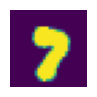

In [13]:
show_image(seven_tensors[30]);

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [15]:
len(stacked_threes.shape)

3

In [16]:
stacked_threes.ndim

3

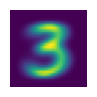

In [17]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

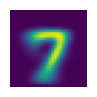

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Here is a sample 3

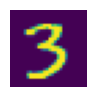

In [19]:
a_3 = stacked_threes[1]
show_image(a_3);

There are two main ways data scientists measure distance in this context:

- Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
- Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

In [20]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [21]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).

In [22]:
#F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Use accuracy as the metric for classification models

In [23]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [24]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [25]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1200, 0.1333, 0.1127,  ..., 0.1323, 0.1283, 0.1078]),
 torch.Size([1010]))

In [26]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

In [27]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [28]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [29]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [30]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

**Stochastic Gradient Descent (SGD)**

Loss function

In [31]:
def f(x): return x**2

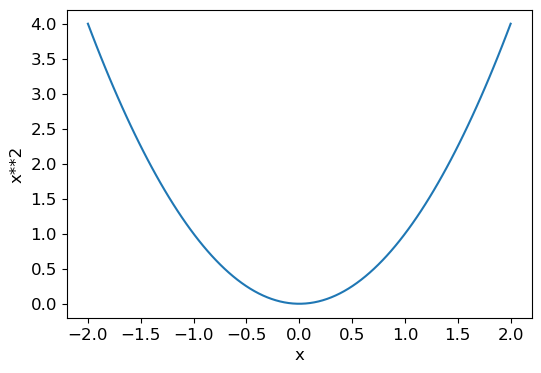

In [32]:
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

In [33]:
@interact(a=-1.6)
def mk_quad(a):
    plot_function(f, 'x', 'x**2')
    plt.scatter(a, f(a), color='red')

interactive(children=(FloatSlider(value=-1.6, description='a', max=1.6, min=-4.800000000000001), Output()), _d…

Finding derivative with PyTorch

In [34]:
xt = tensor(3.0).requires_grad_()

In [35]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [36]:
# calculate_grad
yt.backward()

In [37]:
xt.grad

tensor(6.)

In [38]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [39]:
#And we'll add sum to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor)
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [40]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

**An End-to-End SGD Example**

In [41]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

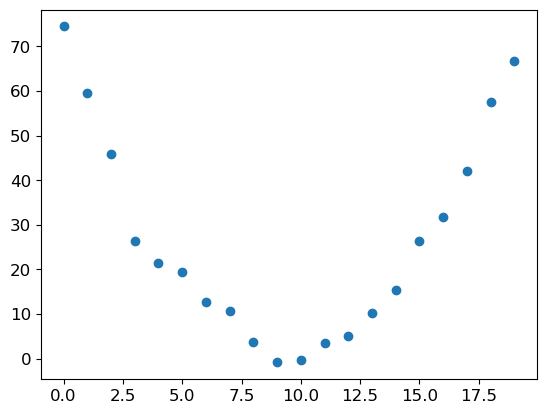

In [42]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [43]:
# let's use a guess that it will be quadratic; i.e., a function of the form a*(time**2)+(b*time)+c.
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [44]:
# loss function - mean squared error 
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

**Step 1: Initialize the parameters**

In [45]:
params = torch.randn(3).requires_grad_()

In [46]:
# clone
orig_params = params.clone()

**Step 2: Calculate the predictions**

In [47]:
preds = f(time, params)

In [48]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

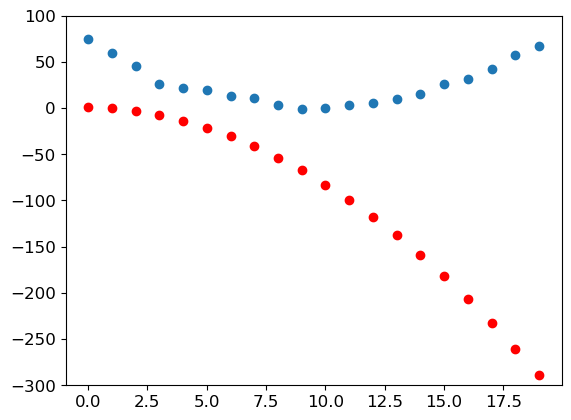

In [49]:
show_preds(preds)

**Step 3: Calculate the loss**

In [50]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

**Step 4: Calculate the gradients**

In [51]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [52]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [53]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

**Step 5: Step the weights**

In [54]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [55]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

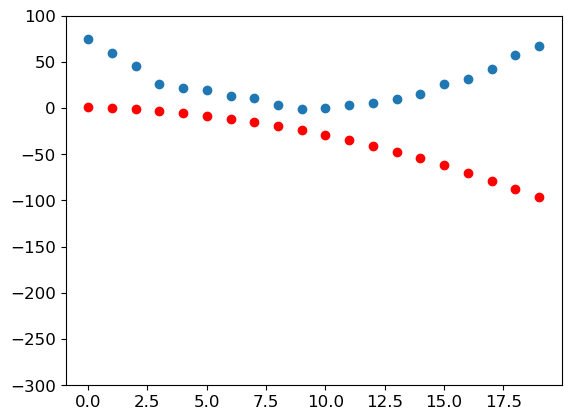

In [56]:
show_preds(preds)

In [57]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

**Step 6: Repeat the process**

In [58]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [59]:
params = orig_params.detach().requires_grad_()

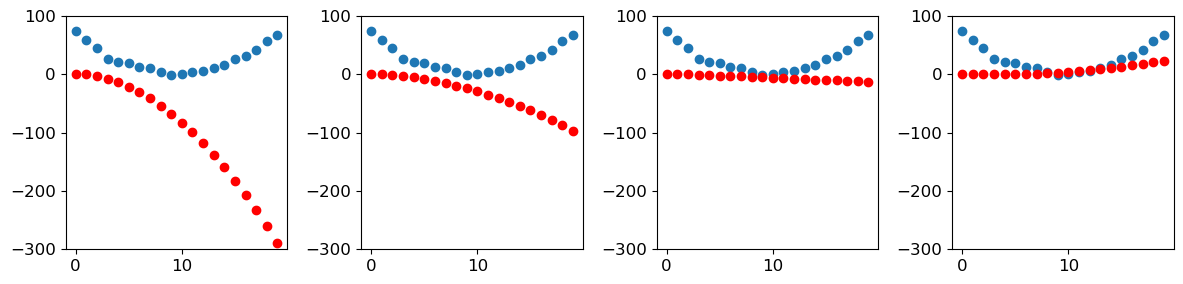

In [60]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

**Step 7: stop**

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

__The MNIST Loss Function__

In [61]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [62]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [63]:
dset = list(zip(train_x,train_y))

In [64]:
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [65]:
# valid set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [66]:
# set random weights
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [67]:
weights = init_params((28*28,1))

In [68]:
bias = init_params(1)

The formula for a line is y=w*x+b

In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters.

In [69]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [70]:
# In Python, matrix multiplication is represented with the @ operator. Let's try it:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

This equation, batch@weights + bias, is one of the two fundamental equations of any neural network (the other one is the activation function, which we'll see in a moment).

In [71]:
# check accuracy
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [72]:
corrects.float().mean().item()

0.4912068545818329

In [73]:
with torch.no_grad(): weights[0] *= 1.0001

In [74]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

In [75]:
# 3, 7, 3
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [76]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [77]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [78]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [79]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

In [80]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() # The sigmoid function always outputs a number between 0 and 1
    return torch.where(targets==1, 1-predictions, predictions).mean()

__SGD and Mini-Batches__

In [81]:
# A DataLoader can take any Python collection and turn it into an iterator over mini-batches, like so:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [82]:
#A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j'),(10, 'k'),(11, 'l'),(12, 'm'),(13, 'n'),(14, 'o'),(15, 'p'),(16, 'q'),(17, 'r'),(18, 's'),(19, 't')...]

In [83]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

**Putting It All Together**

In [84]:
weights = init_params((28*28,1))
bias = init_params(1)

In [85]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [86]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [87]:
# Let's create a mini-batch of size 4 for testing:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [88]:
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [89]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

In [90]:
# Now we can calculate the gradients
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

In [91]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [92]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0121), tensor([-0.0840]))

In [93]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0182), tensor([-0.1260]))

In [94]:
weights.grad.zero_()
bias.grad.zero_();

In [95]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [96]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

In [97]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [98]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [99]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [100]:
validate_epoch(linear1)

0.5261

In [101]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6664

In [102]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8266 0.8901 0.9184 0.9277 0.9399 0.9467 0.9506 0.9526 0.956 0.9579 0.9599 0.9609 0.9614 0.9619 0.9633 0.9638 0.9648 0.9658 0.9673 0.9678 

**Creating an Optimizer**

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our linear1 function with PyTorch's nn.Linear module.

```nn.Linear``` does the same thing as our ```init_params``` and ```linear``` together. It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [103]:
linear_model = nn.Linear(28*28,1)

In [104]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [105]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [106]:
opt = BasicOptim(linear_model.parameters(), lr)

In [107]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [108]:
validate_epoch(linear_model)

0.4607

In [109]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [110]:
train_model(linear_model, 20)

0.4932 0.7686 0.8555 0.9136 0.9346 0.9482 0.957 0.9634 0.9658 0.9678 0.9697 0.9717 0.9736 0.9746 0.9761 0.977 0.9775 0.9775 0.978 0.9785 

In [111]:
#fastai provides the SGD class which, by default, does the same thing as our BasicOptim:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8179 0.8496 0.9141 0.9346 0.9482 0.957 0.9619 0.9658 0.9673 0.9692 0.9712 0.9741 0.9751 0.9761 0.9775 0.9775 0.978 0.9785 0.979 

fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [112]:
dls = DataLoaders(dl, valid_dl)

In [113]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [114]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097721,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


**Adding a Nonlinearity**

In [115]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [116]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

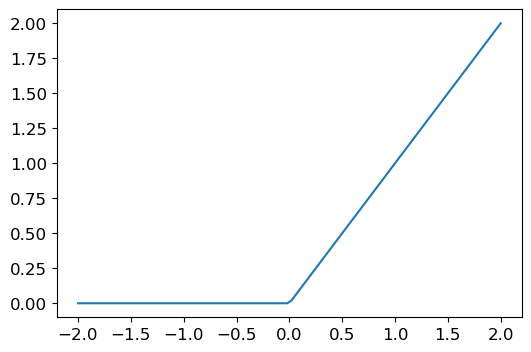

In [117]:
plot_function(F.relu)


In [118]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [119]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [120]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333021,0.396112,0.512267,00:00
1,0.152461,0.235238,0.797350,00:00
2,0.083573,0.117471,0.911678,00:00
3,0.054309,0.078719,0.940628,00:00
4,0.040829,0.061228,0.956330,00:00
5,0.034006,0.051490,0.963690,00:00
6,0.030123,0.045381,0.966634,00:00
7,0.027619,0.041218,0.968106,00:00
8,0.025825,0.038200,0.969087,00:00
9,0.024441,0.035901,0.969578,00:00


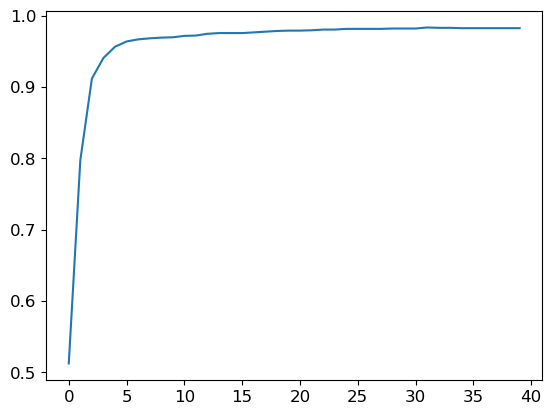

In [121]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [122]:
learn.recorder.values[-1][2]

0.98233562707901

**Going Deeper**

In [129]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.133994,0.020283,0.996565,02:06
